# RRmap RewireSpace Analysis

This notebook runs RewireSpace on your dataset:
`/Volumes/processing2/RRmap/data/RRmap_metadata_fixed_update.h5ad`.

Workflow:
- Inspect available metadata and graph keys
- Load a subset of samples into memory
- Compute per-sample contact/Z matrices
- Fit stage-wise rewiring effects and plot top edges


In [1]:
import sys
from pathlib import Path

for candidate in [Path.cwd() / "src", Path.cwd().parent / "src"]:
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

from rewirespace.spatial_rewiring import per_sample_contacts, fit_stage_effect
from rewirespace.plot_rewiring import plot_stage_heatmaps, plot_rewiring_curves


In [27]:
DATA_PATH = Path("/Volumes/processing2/RRmap/data/RRmap_metadata_fixed_update.h5ad")

# Defaults inferred from this file on 2026-02-19.
CELL_TYPE_KEY = "anno_L2"  # alternatives: "Level2", "Class", "anno_L2"
STAGE_KEY = "stage"
SAMPLE_KEY = "sample_id"
SUBJECT_KEY = None  # e.g. "sample_name" if repeated measures are available
ADJ_KEY = "spatial_connectivities"

# Runtime knobs
SAMPLES_TO_USE = None  # e.g. ["G3_L1_0", "G3_L1_1"]
N_SAMPLES_HEAD = 107
MAX_CELLS_PER_SAMPLE = 15000  # set None to disable downsampling
N_PERM = 50  # increase for final runs (e.g. 100-500)
RANDOM_STATE = 42

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Missing file: {DATA_PATH}")


In [28]:
adata_b = ad.read_h5ad(DATA_PATH, backed="r")

print(adata_b)
print("n_obs:", adata_b.n_obs, "n_vars:", adata_b.n_vars)
print("obsp keys:", list(adata_b.obsp.keys()))
print("obs columns (first 40):", list(adata_b.obs.columns)[:40])

required_obs = [CELL_TYPE_KEY, STAGE_KEY, SAMPLE_KEY]
missing_obs = [k for k in required_obs if k not in adata_b.obs.columns]
if missing_obs:
    raise KeyError(f"Missing required adata.obs keys: {missing_obs}")
if ADJ_KEY not in adata_b.obsp and ADJ_KEY not in adata_b.uns:
    raise KeyError(f"Adjacency key '{ADJ_KEY}' not in adata.obsp/adata.uns.")

sample_counts = adata_b.obs[SAMPLE_KEY].value_counts(dropna=False)
print("n unique samples:", sample_counts.shape[0])
sample_counts.head(12)


AnnData object with n_obs × n_vars = 877141 × 5101 backed at '/Volumes/processing2/RRmap/data/RRmap_metadata_fixed_update.h5ad'
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'louvain_0.5', 'louvain_1', 'louvain_1.5', 'louvain_2', 'louvain_2.5', 'louvain_3', 'louvain_3.5', 'Cluster', 'Level1', 'Level2', 'Level3', 'Level3.1', 'grid_label', 'rbd_domain', 'rbd_domain_0.1', 'rbd_domain_0.2', 'rbd_domain_0.3', 'rbd_domain_0.5', 'rbd_domain_0.6', 'rbd_domain_0.7', 'rbd_domain_0.8', 'rbd_domain_0.9', 'rbd_domain_1.1', 'rbd_domain_1', 'rbd_domain_1.25', 'rbd_domain_1.4', 'rbd_domain_1.5', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'sample_name', 'course', 'condition', 'model', 'cytetype_annotation_louvain_3.5', 'cytetype_cellOntologyTerm_louvain_3.5', 'cluster_id', 'author_label', 'annotation', 'Clas

sample_id
G3_L1_1    19257
S3_B3_0    17380
S2_T1_1    15695
S3_B2_0    15297
S1_B1_0    13844
S2_T2_1    13766
G3_L3_0    13378
S2_B2_0    12878
S4_B3_0    12841
S3_B3_2    12599
S4_B2_1    12218
S2_T3_1    12210
Name: count, dtype: int64

In [29]:
if SAMPLES_TO_USE is None:
    selected_samples = sample_counts.index[:N_SAMPLES_HEAD].tolist()
else:
    selected_samples = list(SAMPLES_TO_USE)

print("selected_samples:", selected_samples)

mask = adata_b.obs[SAMPLE_KEY].isin(selected_samples).to_numpy()
idx = np.flatnonzero(mask)
print("selected cells:", idx.size)
if idx.size == 0:
    raise ValueError("No cells matched selected samples; update SAMPLES_TO_USE or SAMPLE_KEY.")

obs_sub = adata_b.obs.iloc[idx].copy()
adata = ad.AnnData(obs=obs_sub)

if ADJ_KEY in adata_b.obsp:
    A = adata_b.obsp[ADJ_KEY]
    adata.obsp[ADJ_KEY] = A[idx][:, idx].tocsr()
elif ADJ_KEY in adata_b.uns:
    adata.uns[ADJ_KEY] = adata_b.uns[ADJ_KEY]
else:
    raise KeyError(f"Adjacency key '{ADJ_KEY}' not in adata.obsp/adata.uns.")

adata_b.file.close()
print(adata)


selected_samples: ['G3_L1_1', 'S3_B3_0', 'S2_T1_1', 'S3_B2_0', 'S1_B1_0', 'S2_T2_1', 'G3_L3_0', 'S2_B2_0', 'S4_B3_0', 'S3_B3_2', 'S4_B2_1', 'S2_T3_1', 'G4_L1_2', 'G3_L2_1', 'S3_B1_0', 'S3_B1_2', 'G4_L3_1', 'S4_T2_1', 'S1_T3_1', 'G3_L1_0', 'S2_B3_0', 'S4_B3_1', 'G4_L2_0', 'S4_T3_0', 'S4_B3_2', 'G3_L2_0', 'S1_B2_1', 'S1_T2_2', 'S1_T3_2', 'S3_B3_1', 'S2_B2_1', 'S4_B1_1', 'S3_T3_1', 'S4_B2_2', 'S2_B1_2', 'S4_B2_0', 'S3_T2_0', 'OS2-1_C', 'S2_T1_0', 'G4_L2_1', 'S1_T3_0', 'G6_L1_1', 'S1_B3_0', 'S2_T1_2', 'OS2-2_C', 'S4_T2_2', 'G6_L3_0', 'S4_T1_1', 'G3_L3_1', 'S1_B2_0', 'S3_T2_1', 'S3_T3_2', 'S1_B3_2', 'S4_T1_0', 'S4_B1_0', 'OS2-1_L', 'S2_T2_0', 'S1_T1_1', 'G5_L2_1', 'S3_T1_2', 'S4_B1_2', 'G3_L1_2', 'G5_L3_0', 'S1_B1_2', 'S1_B3_1', 'G4_L3_0', 'S1_T2_1', 'G4_L3_2', 'G5_L1_2', 'G6_L1_2', 'S1_B1_1', 'G6_L3_1', 'S2_B3_2', 'S4_T3_1', 'G5_L2_0', 'G4_L1_1', 'S3_T3_0', 'S4_T3_2', 'G4_L2_2', 'S3_T1_0', 'S3_T1_1', 'S2_B2_2', 'S2_T3_0', 'S3_T2_2', 'OS2-2_L', 'G5_L3_1', 'G3_L3_2', 'G6_L2_2', 'G6_L3_2', 'S

In [30]:
if MAX_CELLS_PER_SAMPLE is not None:
    rng = np.random.default_rng(RANDOM_STATE)
    sample_vals = adata.obs[SAMPLE_KEY].to_numpy()
    keep_pos = []
    for sid in pd.unique(sample_vals):
        pos = np.flatnonzero(sample_vals == sid)
        if pos.size > MAX_CELLS_PER_SAMPLE:
            pos = rng.choice(pos, size=MAX_CELLS_PER_SAMPLE, replace=False)
        keep_pos.append(np.sort(pos))

    keep_pos = np.concatenate(keep_pos)
    keep_pos.sort()
    keep_pos = np.asarray(keep_pos, dtype=np.int64)

    obs_sub = adata.obs.iloc[keep_pos].copy()
    adata_ds = ad.AnnData(obs=obs_sub)

    if ADJ_KEY in adata.obsp:
        A = adata.obsp[ADJ_KEY]
        A = A.tocsr()
        try:
            kp = keep_pos.astype(np.int32, copy=False)
            A_sub = A[kp][:, kp].tocsr()
        except Exception:
            from scipy import sparse

            coo = A.tocoo()
            old_to_new = np.full(A.shape[0], -1, dtype=np.int64)
            old_to_new[keep_pos] = np.arange(keep_pos.size, dtype=np.int64)
            edge_mask = (old_to_new[coo.row] >= 0) & (old_to_new[coo.col] >= 0)
            A_sub = sparse.csr_matrix(
                (
                    coo.data[edge_mask],
                    (old_to_new[coo.row[edge_mask]], old_to_new[coo.col[edge_mask]]),
                ),
                shape=(keep_pos.size, keep_pos.size),
            )

        adata_ds.obsp[ADJ_KEY] = A_sub
    elif ADJ_KEY in adata.uns:
        adata_ds.uns[ADJ_KEY] = adata.uns[ADJ_KEY]
    else:
        raise KeyError(f"Adjacency key '{ADJ_KEY}' not in adata.obsp/adata.uns.")

    adata = adata_ds
    print(f"Downsampled to {adata.n_obs} cells (max {MAX_CELLS_PER_SAMPLE} per sample).")

if isinstance(adata.obs[STAGE_KEY].dtype, pd.CategoricalDtype):
    print("Using existing categorical stage order.")
else:
    stage_vals = [v for v in pd.unique(adata.obs[STAGE_KEY]) if pd.notna(v)]
    try:
        stage_order = sorted(stage_vals)
    except TypeError:
        stage_order = stage_vals
    adata.obs[STAGE_KEY] = pd.Categorical(adata.obs[STAGE_KEY], categories=stage_order, ordered=True)
    print("Inferred stage order:", stage_order)


Downsampled to 869512 cells (max 15000 per sample).
Using existing categorical stage order.


In [31]:
subject_key_for_contacts = SUBJECT_KEY if (SUBJECT_KEY is not None and SUBJECT_KEY in adata.obs.columns) else None
if SUBJECT_KEY is not None and subject_key_for_contacts is None:
    print(f"Subject key '{SUBJECT_KEY}' not found in adata.obs; running without subject-level adjustment.")

df_long = per_sample_contacts(
    adata=adata,
    adj_key=ADJ_KEY,
    cell_type_key=CELL_TYPE_KEY,
    sample_key=SAMPLE_KEY,
    stage_key=STAGE_KEY,
    subject_key=subject_key_for_contacts,
    n_perm=N_PERM,
)

print(df_long.shape)
df_long.head()


Per-sample contacts: 100%|██████████| 107/107 [00:03<00:00, 28.01it/s]

(47187, 8)


,sample_id,stage,type_i,type_j,C_obs,Z,n_cells,n_edges
0,G3_L1_0,OS1,Arachnoid barrier,Arachnoid barrier,4.0,14.142857,10909,64348
1,G3_L1_0,OS1,Arachnoid barrier,Artifact,0.0,-1.577457,10909,64348
2,G3_L1_0,OS1,Arachnoid barrier,Astrocyte,1.0,-2.904198,10909,64348
3,G3_L1_0,OS1,Arachnoid barrier,B cell,0.0,-0.142857,10909,64348
4,G3_L1_0,OS1,Arachnoid barrier,BAM,0.0,-0.531085,10909,64348


In [32]:
summary = (
    df_long.groupby("stage", observed=False)
    .agg(
        n_samples=("sample_id", "nunique"),
        n_rows=("type_i", "size"),
        mean_abs_Z=("Z", lambda x: float(np.mean(np.abs(x)))),
    )
    .reset_index()
)
summary


,stage,n_samples,n_rows,mean_abs_Z
0,LONG,10,4410,6.320065
1,MOG CFA,6,2646,4.663661
2,MONOPHASIC,12,5292,6.151436
3,NONSYMPTOM,6,2646,4.065416
4,ONSET1,6,2646,4.805214
5,ONSET2,6,2646,5.297805
6,OS1,8,3528,5.837100
7,PEAK1,15,6615,6.424236
8,PEAK2,9,3969,6.069362
9,PEAK3,9,3969,7.101886


In [33]:
subject_col_for_model = "subject" if (subject_key_for_contacts is not None and "subject" in df_long.columns) else None

results = fit_stage_effect(
    df_long=df_long,
    value_col="Z",
    stage_col="stage",
    subject_col=subject_col_for_model,
)

print(results.shape)
results.head(20)


Stage models: 100%|██████████| 441/441 [00:00<00:00, 482.69it/s]

(441, 12)


,rank,type_i,type_j,n_obs,n_samples,n_stages,effect_range,coef_abs_max,p_value,q_value,model,r_squared
0,1,Microglia,Microglia,107,107,13,29.419499,27.459363,4.307335e-22,1.899535e-19,ols,0.735284
1,2,Interneuron,Microglia,107,107,13,19.548649,19.548649,4.196654e-20,6.169081e-18,ols,0.707011
2,3,Microglia,Interneuron,107,107,13,19.548649,19.548649,4.196654e-20,6.169081e-18,ols,0.707011
3,4,Neuron,T cell,107,107,13,11.718410,6.861298,7.785324e-16,6.866655e-14,ols,0.634840
4,5,T cell,Neuron,107,107,13,11.718410,6.861298,7.785324e-16,6.866655e-14,ols,0.634840
5,6,Dendritic cell,Neuron,107,107,13,7.007368,3.898930,1.541319e-14,9.710309e-13,ols,0.609244
6,7,Neuron,Dendritic cell,107,107,13,7.007368,3.898930,1.541319e-14,9.710309e-13,ols,0.609244
7,8,Other,T cell,107,107,13,3.927174,2.160781,3.052966e-14,1.495953e-12,ols,0.603108
8,9,T cell,Other,107,107,13,3.927174,2.160781,3.052966e-14,1.495953e-12,ols,0.603108
9,10,Interneuron,Macrophage,107,107,13,23.240780,17.583063,4.929759e-14,1.976385e-12,ols,0.598742


In [34]:
tmp = results.copy()
tmp["_q"] = tmp["q_value"].fillna(1.0)
top_edges = tmp.sort_values(["_q", "effect_range"], ascending=[True, False]).drop(columns="_q").head(10)
top_edges[["rank", "type_i", "type_j", "effect_range", "p_value", "q_value", "model"]]


,rank,type_i,type_j,effect_range,p_value,q_value,model
0,1,Microglia,Microglia,29.419499,4.307335e-22,1.899535e-19,ols
1,2,Interneuron,Microglia,19.548649,4.196654e-20,6.169081e-18,ols
2,3,Microglia,Interneuron,19.548649,4.196654e-20,6.169081e-18,ols
3,4,Neuron,T cell,11.718410,7.785324e-16,6.866655e-14,ols
4,5,T cell,Neuron,11.718410,7.785324e-16,6.866655e-14,ols
5,6,Dendritic cell,Neuron,7.007368,1.541319e-14,9.710309e-13,ols
6,7,Neuron,Dendritic cell,7.007368,1.541319e-14,9.710309e-13,ols
7,8,Other,T cell,3.927174,3.052966e-14,1.495953e-12,ols
8,9,T cell,Other,3.927174,3.052966e-14,1.495953e-12,ols
9,10,Interneuron,Macrophage,23.240780,4.929759e-14,1.976385e-12,ols


/Users/christoffer/work/karolinska/development/RewireSpace/src/rewirespace/plot_rewiring.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


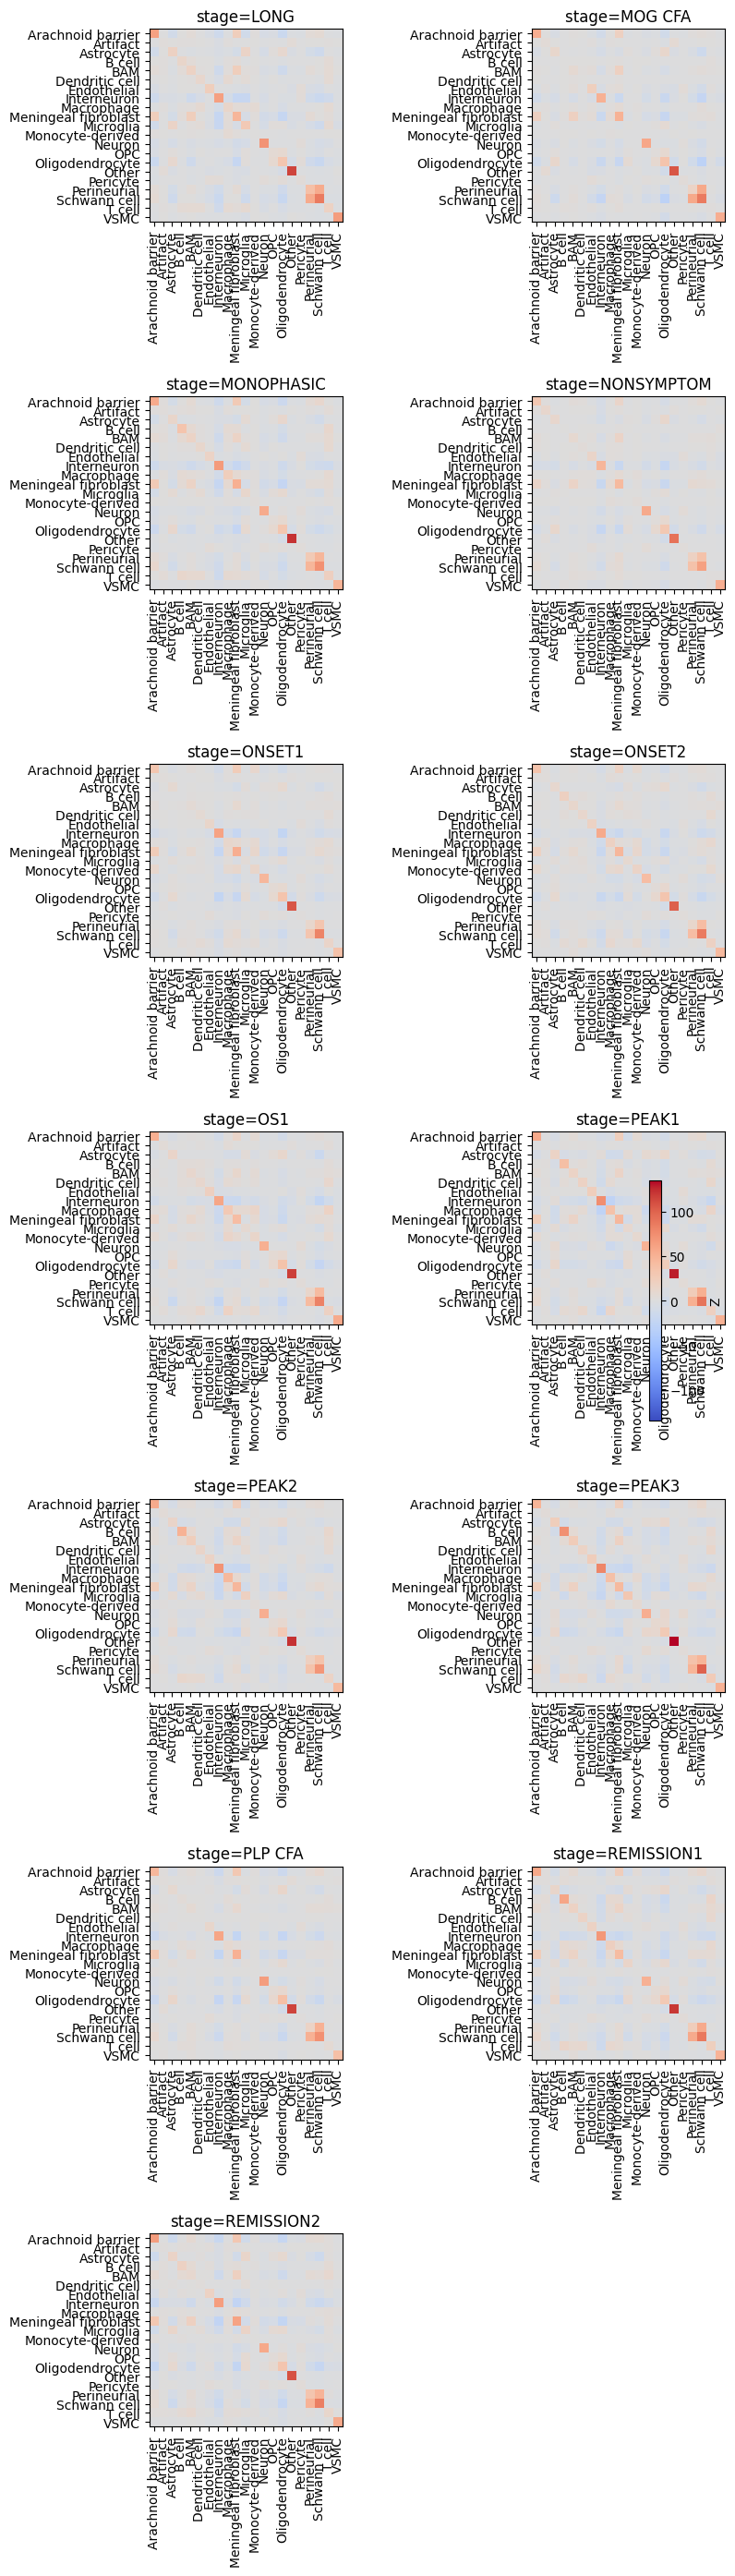

In [35]:
fig, axes = plot_stage_heatmaps(
    df_long=df_long,
    value_col="Z",
    stage_col="stage",
    ncols=2,
)
plt.show()


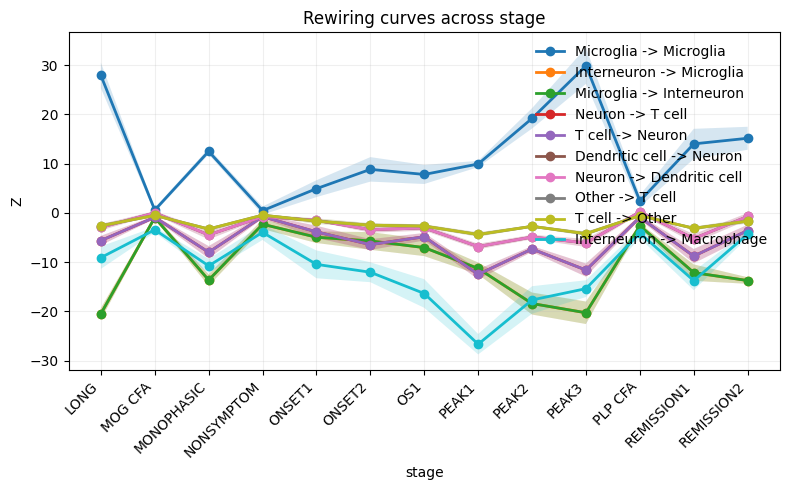

In [37]:
pairs = list(top_edges[["type_i", "type_j"]].itertuples(index=False, name=None))[:10]
fig, ax = plot_rewiring_curves(
    df_long=df_long,
    pairs=pairs,
    value_col="Z",
    stage_col="stage",
    show_sem=True,
)
plt.show()


In [ ]:
out_prefix = "rrmap_rewiring"
df_long.to_csv(f"{out_prefix}_per_sample_contacts.csv", index=False)
results.to_csv(f"{out_prefix}_stage_effects.csv", index=False)
print(f"Saved {out_prefix}_per_sample_contacts.csv and {out_prefix}_stage_effects.csv")
